<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/GAN/pizzaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from functools import partial
from google_drive_downloader import GoogleDriveDownloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [ ]:
id = "1cxIZCGZqzLALoN7Ua2HiyRsdNH71a93L"
folder = "pizzaGANdata"
GoogleDriveDownloader.download_file_from_google_drive(file_id = id,
                                                      dest_path = "/content/" + folder + ".zip",
                                                      unzip = True)

Unzipping...Done.


In [ ]:
BATCH_SIZE = 16

# mapping function for preprocessing the image files
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  img = tf.io.decode_jpeg(tf.io.read_file(file), channels = 3)
  img = tf.image.resize(img, size = (64,64))
  x = tf.cast(img, tf.float32) / 127.5 - 1.0
  return x

# create training batches
filename_dataset = tf.data.Dataset.list_files("/content/pizzaGANdata/images/*.jpg")
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)

In [ ]:
conv_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
norm_init = tf.keras.initializers.RandomNormal(mean = 1.0, stddev = 0.02)
# conv_init = "glorot_uniform"
# norm_init = "ones"
def Normalization(tipo, norm_init):
    if tipo == "layer":
        return tf.keras.layers.LayerNormalization(gamma_initializer = norm_init)
    elif tipo == "batch":
        return tf.keras.layers.BatchNormalization(gamma_initializer = norm_init)

In [ ]:
# You'll pass the random_normal_dimensions to the first dense layer of the generator
random_normal_dimensions = BATCH_SIZE

activation2 = "selu"
activation = None
tipo = "layer"


generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 256, input_shape = [random_normal_dimensions]),
    tf.keras.layers.Reshape( [1, 1, 256] ),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 1, 
                                    padding = "valid", activation = activation, use_bias = True,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = True,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = True,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = activation, use_bias = True,
                                    kernel_initializer = conv_init),
    Normalization(tipo, norm_init),
    tf.keras.layers.Activation(activation = activation2),

    tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 4, strides = 2, 
                                    padding = "same", activation = "tanh",
                                    kernel_initializer = conv_init)
], name = "generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
layer_normalization_10 (Laye (None, 1, 1, 256)         512       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 256)         1048832   
_________________________________________________________________
layer_normalization_11 (Laye (None, 4, 4, 256)         512       
_________________________________________________________________
activation_9 (Activation)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         10

In [ ]:
tipo = "layer"
activation = None
activation2 = tf.keras.layers.LeakyReLU(alpha = 0.2)

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = "same", 
                           activation = activation, 
                           input_shape = [64,64,3]),
    tf.keras.layers.Activation(activation = activation2),
    tf.keras.layers.Dropout(0.4),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = "same", 
                           activation = activation, use_bias = True),
    tf.keras.layers.Activation(activation = activation2),
    tf.keras.layers.Dropout(0.4),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = "same", 
                           activation = activation, use_bias = True),
    tf.keras.layers.Activation(activation = activation2),
    tf.keras.layers.Dropout(0.4),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = "same", 
                           activation = activation, use_bias = True),
    tf.keras.layers.Activation(activation = activation2),
    tf.keras.layers.Dropout(0.4),
    Normalization(tipo, norm_init),

    tf.keras.layers.Conv2D(filters = 1024, kernel_size = 3, strides = 2, padding = "valid", 
                           activation = activation, use_bias = True),
    tf.keras.layers.Activation(activation = activation2),
    tf.keras.layers.Dropout(0.4),
    Normalization(tipo, norm_init),

    # tf.keras.layers.Conv2D(filters = 2048, kernel_size = 3, strides = 2, padding = "same", 
    #                        activation = activation, use_bias = True),
    # Normalization(tipo, norm_init),
    # tf.keras.layers.Activation(activation = activation2),
    # tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation = "sigmoid")
   
], name = "discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
layer_normalization_15 (Laye (None, 32, 32, 64)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_14 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)     

In [ ]:
discriminator.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5))
discriminator.trainable = False

gan = tf.keras.models.Sequential([generator, discriminator])
gan.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5))

In [ ]:
def plot_results(images, n_cols = None, epoch = None, disc_loss = None, gen_loss = None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.7))

    try:
        epoca = str(epoch + 1).zfill(3)         
        plt.suptitle("Epoch: {}, disc_loss: {:.4f}, gen_loss: {:.4f}".format(epoca, disc_loss, gen_loss))
    except:
        pass

    for index, image in enumerate(images):
        image = (image + 1) * 127.5
        image = tf.dtypes.cast(image, tf.uint32)
        plt.subplots_adjust(hspace = 0.3)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        try:
            tf.keras.preprocessing.image.save_img("/content/images5/{}_{}.png".format(epoca,index), image)
        except:
            pass
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            
            # infer batch size from the current batch of real images
            real_BATCH_SIZE = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal([real_BATCH_SIZE, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis = 0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * real_BATCH_SIZE + [[1.]] * real_BATCH_SIZE)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            disc_loss = discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal([real_BATCH_SIZE, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * real_BATCH_SIZE)
            
            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gen_loss = gan.train_on_batch(noise, generator_labels)
        
        
        plot_results(fake_images, 4, epoch, disc_loss, gen_loss)                     
        plt.show()
    return fake_images

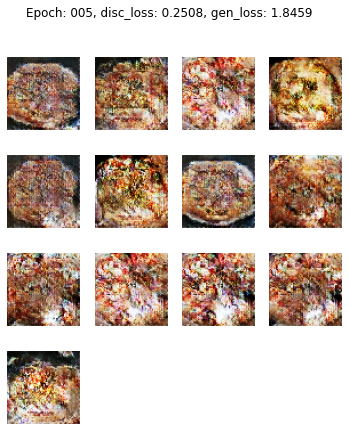

Epoch 6/200


KeyboardInterrupt: ignored

In [ ]:
# you can adjust the number of epochs
EPOCHS = 200
# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

In [ ]:
gan.save("pizza_gan.h5")

In [ ]:
def gradient_penalty(f, real, fake):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp
    gp = _gradient_penalty(f, real, fake)
    return gp

def train_on_batch(real_img):
    '''trains the GAN on a given batch'''

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal([16, random_normal_dimensions])

        # generate fake images
        fake_img = generator(z)

        # feed the fake images to the discriminator
        fake_out = discriminator(fake_img)

        # feed the real images to the discriminator
        real_out = discriminator(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss) 
        d_loss = tf.reduce_sum(d_loss) / (BATCH_SIZE * 2)

        # Gradient Penalty (ignore if you set mode to `none`)
        gp = gradient_penalty(partial(discriminator, training=True), real_img, fake_img)
        gp = gp  / (BATCH_SIZE * 2)
        d_loss = d_loss + gp * gradient_penalty_weight

    # get the gradients
    gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, discriminator.trainable_variables))
    

    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal([16, random_normal_dimensions])
        
        # generate fake images
        fake_img = generator(z)

        # feed fake images to the discriminator
        fake_out = discriminator(fake_img)
        
        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. discriminator should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (BATCH_SIZE * 2)
    
    # get the gradients
    gradients = g_tape.gradient(g_loss, generator.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, generator.trainable_variables))
    
    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img 

In [ ]:
def gan_train(gan, dataset, random_normal_dimensions, n_epochs=50):
    noise = tf.random.normal([16, random_normal_dimensions])
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            if real_images.shape[0] != BATCH_SIZE:
                continue
            d_loss, g_loss, fake_images = train_on_batch(real_images)
        plot_results(fake_images, 4)                     
        plt.show()
        print(d_loss, g_loss) 
    return fake_images

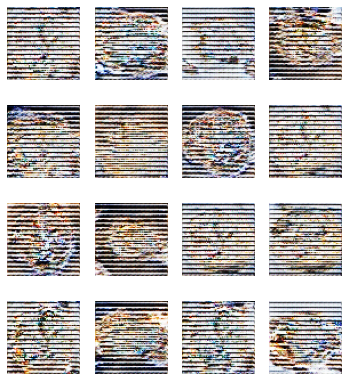

tf.Tensor(0.57955927, shape=(), dtype=float32) tf.Tensor(3.71514e-08, shape=(), dtype=float32)
Epoch 5/50


KeyboardInterrupt: ignored

In [ ]:
gradient_penalty_weight = 5
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5)
param_D = optimizer
param_G = optimizer
fake_images = gan_train(gan, image_dataset, random_normal_dimensions)

In [ ]:
!zip -r /content/images5.zip /content/images5/
files.download("/content/images5.zip")

  adding: content/images5/ (stored 0%)
  adding: content/images5/088_27.png (stored 0%)
  adding: content/images5/055_13.png (stored 0%)
  adding: content/images5/021_12.png (stored 0%)
  adding: content/images5/021_19.png (stored 0%)
  adding: content/images5/048_0.png (stored 0%)
  adding: content/images5/084_16.png (stored 0%)
  adding: content/images5/055_22.png (stored 0%)
  adding: content/images5/071_21.png (stored 0%)
  adding: content/images5/077_0.png (stored 0%)
  adding: content/images5/080_24.png (stored 0%)
  adding: content/images5/066_10.png (stored 0%)
  adding: content/images5/091_23.png (stored 0%)
  adding: content/images5/100_24.png (stored 0%)
  adding: content/images5/084_13.png (stored 0%)
  adding: content/images5/018_1.png (stored 0%)
  adding: content/images5/069_3.png (stored 0%)
  adding: content/images5/077_20.png (stored 0%)
  adding: content/images5/033_1.png (stored 0%)
  adding: content/images5/088_21.png (stored 0%)
  adding: content/images5/039_18.pn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/pizza_gan.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>